## Random Forest

In [2]:
import numpy as np
import pandas as pd
from sklearn.cross_validation import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from time import time
from operator import itemgetter
import time
from scipy import stats
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import roc_curve, auc

from sklearn.ensemble import RandomForestClassifier

from sklearn import (preprocessing, metrics, cross_validation)

from sklearn.externals import joblib


C:\Users\hulabapp\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
# Visualizing data
datapath = 'D:/Dropbox (Nate)/Rotation 3 Project/Data/FeatData/featurematrixandtarget_10h'
# datapath= '/Users/ignacioperez-pozuelo/Dropbox/Rotation 3 Project/Data/FeatData/featurematrixandtarget_20h'
datacontent = sio.loadmat(datapath)

X = datacontent['featm']
X = np.nan_to_num(X) # replace nan with 0
nsubjects = X.shape[0]

Yv = datacontent['y']
Y = np.ravel(Yv)

In [3]:
#upsample class 1

def upsample(data, labels):
    """
    Using upsampling to balance the classes. Note that every data point is included at least once
    and additional data points are added by sampling with replacement.
    """
    from collections import defaultdict
    import random

    label_indices = defaultdict(lambda: list())
    for idx, label in enumerate(labels):
        label_indices[label].append(idx)

    largest_class_size = max(map(lambda l: len(l), label_indices.values()))

    upsampled_indices = []
    for label, indices in label_indices.items():
        sampled_indices = indices[:]
        while len(sampled_indices) < largest_class_size:
            sampled_indices.append(random.choice(indices))
        upsampled_indices.extend(sampled_indices)

    upsampled_labels = labels[upsampled_indices]
    upsampled_data = data[upsampled_indices, :]

    return upsampled_data, upsampled_labels

def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Input:
    target values 
    predicted values
    
    Returns
    optimal cutoff value
    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.ix[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 


In [39]:
# divide into test set and training set

start = time.time()

datapath = 'H:/MatlabProjects/Nate/Dropbox/Rotation 3 Project/Data/FullData/featurematrixandtarget_05h'
datacontent = sio.loadmat(datapath)

X_tot = datacontent['featm']
X_tot = np.nan_to_num(X_tot) # replace nan with 0
nsubjects = X_tot.shape[0]
X_tot = stats.zscore(X_tot)
# scaler = preprocessing.MinMaxScaler().fit(X_tot)
# X_tot = scaler.transform(X_tot)

Yv = datacontent['y']
Y_tot = np.ravel(Yv)

# datapath = 'D:/Dropbox (Nate)/Rotation 3 Project/Data/FeatData_Agg/feature_10h.csv'
# datapath_y = 'D:/Dropbox (Nate)/Rotation 3 Project/Data/FeatData_Agg/target_10h.csv'
# # datapath= '/Users/ignacioperez-pozuelo/Dropbox/Rotation 3 Project/Data/FeatData/featurematrixandtarget_20h'
# X = pd.read_csv(datapath)
# X = np.nan_to_num(X) # replace nan with 0

# Y = pd.read_csv(datapath_y)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=None)
for train_index, test_index in sss.split(X_tot, Y_tot):
    X, X_test = X_tot[train_index], X_tot[test_index]
    Y, Y_test = Y_tot[train_index], Y_tot[test_index]

print(Y.shape)
print(Y_test.shape)
    
X,Y = upsample(X,Y)
X_test, Y_test = upsample(X_test, Y_test)

print(Y.shape)
print(Y_test.shape)
    
loo = LeaveOneOut()
fold = StratifiedKFold(Y, n_folds=10, shuffle=True, random_state=0)
SP = StratifiedShuffleSplit(n_splits=50, test_size=.1, random_state=0)

rs = {"n_estimators": [10, 50, 100, 300, 500],
              "max_depth": range(2,10),
              "max_features": [1, 2, 3, 4, 5, 6],
              "min_samples_split": range(2,10),
              "min_samples_leaf": range(2,10),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]} 

#     score = None
# Using LogisticRegressionCV (cross validation search for Logistic regression) and report ROC_AUC score
clf = RandomForestClassifier(class_weight = 'balanced')
searchCV = RandomizedSearchCV(clf, rs, n_iter=1000, scoring='roc_auc', cv=SP, n_jobs=-1)

searchCV.fit(X_tot, Y_tot)

cvs_score = searchCV.cv_results_['mean_test_score'][searchCV.best_index_]
cvs_std = searchCV.cv_results_['std_test_score'][searchCV.best_index_]
param = searchCV.cv_results_['params'][searchCV.best_index_]

print(cvs_score,cvs_std)
print(param)

end = time.time()
print (end - start)

(61,)
(41,)
(84,)
(58,)
0.6975 0.188710904708
{'n_estimators': 100, 'min_samples_split': 9, 'min_samples_leaf': 9, 'max_features': 2, 'max_depth': 5, 'criterion': 'gini', 'bootstrap': False}
615.8619680404663


In [40]:
grid_scores = searchCV.grid_scores_
top_scores = sorted(grid_scores,
                    key=itemgetter(1),
                    reverse=True)[:5]
for i, score in enumerate(top_scores):
    print("Model with rank: {0}".format(i + 1))
    print(("Mean validation score: "
           "{0:.3f} (std: {1:.3f})").format(
           score.mean_validation_score,
           np.std(score.cv_validation_scores)))
    print("Parameters: {0}".format(score.parameters))
    print("")

# clfs = [RandomForestClassifier(**{'n_estimators'= 500, 'min_samples_split': 6, 'min_samples_leaf': 9, 'max_features': 2, 'max_depth': 6, 'criterion': 'gini', 'bootstrap': False}),
#         RandomForestClassifier(**{'n_estimators': 300, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 1, 'max_depth': 5, 'criterion': 'gini', 'bootstrap': False}),
#         RandomForestClassifier(**{'n_estimators': 300, 'min_samples_split': 7, 'min_samples_leaf': 8, 'max_features': 2, 'max_depth': 9, 'criterion': 'gini', 'bootstrap': False}),
#         RandomForestClassifier(**{'n_estimators': 50, 'min_samples_split': 9, 'min_samples_leaf': 7, 'max_features': 3, 'max_depth': 4, 'criterion': 'entropy', 'bootstrap': True}),
#         RandomForestClassifier(**{'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 9, 'max_features': 2, 'max_depth': 4, 'criterion': 'gini', 'bootstrap': False})]


Model with rank: 1
Mean validation score: 0.698 (std: 0.189)
Parameters: {'n_estimators': 100, 'min_samples_split': 9, 'min_samples_leaf': 9, 'max_features': 2, 'max_depth': 5, 'criterion': 'gini', 'bootstrap': False}

Model with rank: 2
Mean validation score: 0.697 (std: 0.207)
Parameters: {'n_estimators': 50, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 1, 'max_depth': 8, 'criterion': 'gini', 'bootstrap': False}

Model with rank: 3
Mean validation score: 0.697 (std: 0.201)
Parameters: {'n_estimators': 10, 'min_samples_split': 8, 'min_samples_leaf': 8, 'max_features': 1, 'max_depth': 4, 'criterion': 'entropy', 'bootstrap': False}

Model with rank: 4
Mean validation score: 0.697 (std: 0.211)
Parameters: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 6, 'max_features': 2, 'max_depth': 8, 'criterion': 'gini', 'bootstrap': False}

Model with rank: 5
Mean validation score: 0.696 (std: 0.224)
Parameters: {'n_estimators': 500, 'min_samples_split': 6, 'min_

C:\Users\hulabapp\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


Area is 0.92


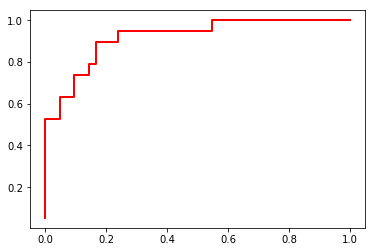

[0.545346810744476]
[[36  6]
 [ 4 15]]


In [20]:
clf_sub = RandomForestClassifier(**param, class_weight = 'balanced', n_jobs=-1)

Y_proba = clf_sub.fit(X,Y).predict_proba(X)
Y_pred = clf_sub.fit(X,Y).predict(X)
# Y_df = clf_sub.fit(X,Y).decision_function(X)

roc_auc_score = []
# fpr, tpr, thresholds = roc_curve(Y, Y_df)
fpr, tpr, thresholds = roc_curve(Y, Y_proba[:,1])
roc_auc = auc(fpr, tpr)
roc_auc_score.append(roc_auc)
print('Area is %0.2f' %roc_auc)
plt.plot(fpr, tpr, lw=2, color='red')
plt.show() 

threshold = Find_Optimal_Cutoff(Y, Y_proba[:,1])
# threshold = .525
Y_predict = list(map(lambda x: 1 if x > threshold else 0, Y_proba[:,1]))
print (threshold)

print(confusion_matrix(Y, Y_predict))




In [6]:
Y_proba

array([[ 0.40701862,  0.59298138],
       [ 0.57187358,  0.42812642],
       [ 0.77089742,  0.22910258],
       [ 0.83129327,  0.16870673],
       [ 0.93891746,  0.06108254],
       [ 0.67190218,  0.32809782],
       [ 0.73179968,  0.26820032],
       [ 0.7470951 ,  0.2529049 ],
       [ 0.86171835,  0.13828165],
       [ 0.85991112,  0.14008888],
       [ 0.44525575,  0.55474425],
       [ 0.90467206,  0.09532794],
       [ 0.87276923,  0.12723077],
       [ 0.8150429 ,  0.1849571 ],
       [ 0.71891843,  0.28108157],
       [ 0.7242694 ,  0.2757306 ],
       [ 0.73940633,  0.26059367],
       [ 0.67138426,  0.32861574],
       [ 0.52135807,  0.47864193],
       [ 0.87541573,  0.12458427],
       [ 0.5299508 ,  0.4700492 ],
       [ 0.4587098 ,  0.5412902 ],
       [ 0.67859012,  0.32140988],
       [ 0.25188114,  0.74811886],
       [ 0.55425253,  0.44574747],
       [ 0.71280811,  0.28719189],
       [ 0.83585285,  0.16414715],
       [ 0.77065092,  0.22934908],
       [ 0.53328125,

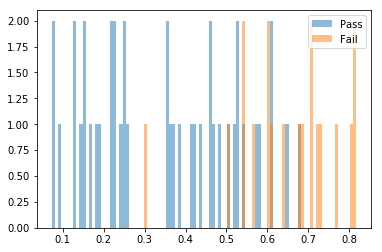

In [21]:
bins = np.linspace(min(Y_proba[:,1]), max(Y_proba[:,1]), 100)

plt.hist(Y_proba[:,1][Y==0], bins, alpha=0.5, label='Pass')
plt.hist(Y_proba[:,1][Y==1], bins, alpha=0.5, label='Fail')
plt.legend(loc='upper right')
plt.show()



Area is 0.67


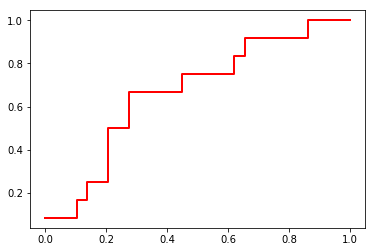

[[21  8]
 [ 5  7]]


In [22]:
Y_proba = clf_sub.fit(X,Y).predict_proba(X_test)
Y_pred = clf_sub.fit(X,Y).predict(X_test)
# Y_df = clf_sub.fit(X,Y).decision_function(X_test)

# threshold = 

Y_predict = list(map(lambda x: 1 if x > threshold else 0, Y_proba[:,1]))

# Print confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test, Y_predict)

roc_auc_score = []
# fpr, tpr, thresholds = roc_curve(Y_test, Y_df)
fpr, tpr, thresholds = roc_curve(Y_test, Y_proba[:,1])
roc_auc = auc(fpr, tpr)
roc_auc_score.append(roc_auc)
print('Area is %0.2f' %roc_auc)
plt.plot(fpr, tpr, lw=2, color='red')
plt.show() 

print(confusion_matrix(Y_test, Y_predict))

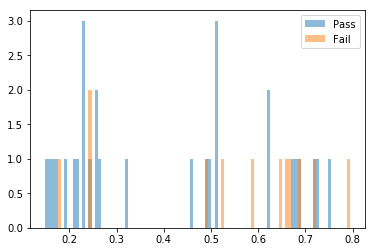

In [23]:
bins = np.linspace(min(Y_proba[:,1]), max(Y_proba[:,1]), 100)

plt.hist(Y_proba[:,1][Y_test==0], bins, alpha=0.5, label='Pass')
plt.hist(Y_proba[:,1][Y_test==1], bins, alpha=0.5, label='Fail')
plt.legend(loc='upper right')
plt.show()



In [296]:
# Import Data and Using Stratified K fold for the data

def get_score(datapath, score_type):
    start = time.time()

#     datapath = 'D:/Dropbox (Nate)/Rotation 3 Project/Data/FeatData/featurematrixandtarget_1h'
    #     datapath='/Users/ignacioperez-pozuelo/Dropbox/Rotation 3 Project/Data/FeatData/featurematrixandtarget_24h'
    datacontent = sio.loadmat(datapath)

    X_tot = datacontent['featm']
    X_tot = np.nan_to_num(X_tot) # replace nan with 0
    nsubjects = X_tot.shape[0]

    Yv = datacontent['y']
    Y_tot = np.ravel(Yv)
    
    sss = StratifiedShuffleSplit(Y_tot, n_iter=1, test_size=0.5, random_state=0)
    len(sss)
    for train_index, test_index in sss:
        X, X_test = X_tot[train_index], X_tot[test_index]
        Y, Y_test = y_tot[train_index], y_tot[test_index]

    loo = LeaveOneOut()
    fold = StratifiedKFold(Y, n_folds=5, shuffle=True, random_state=0)
    SP = StratifiedShuffleSplit(n_splits=20, test_size=(7/len(Y[Y==1])), random_state=0)

    grid = {'C': np.power(10.0, np.arange(-15, 10)), 'solver':['newton-cg'],'class_weight':['balanced', None], 'max_iter':[10000,100000]}
#     score = None
    # Using LogisticRegressionCV (cross validation search for Logistic regression) and report ROC_AUC score
    clf = LogisticRegression(penalty='l2'
        ,random_state=0
        ,fit_intercept=True
        ,tol=.001)
    searchCV = GridSearchCV(clf, grid, scoring=score_type, cv=SP)

    searchCV.fit(X, Y)

    cvs_score = searchCV.cv_results_['mean_test_score'][searchCV.best_index_]
    cvs_std = searchCV.cv_results_['std_test_score'][searchCV.best_index_]
    param = searchCV.cv_results_['params'][searchCV.best_index_]
    
    end = time.time()
    print (end - start)

    return cvs_score, cvs_std, param, X, Y


#     print ('Max auc_roc:', searchCV.scores_[1].mean(axis=0).max())
#     print ('Std auc_roc:', searchCV.scores_[1].std(axis=0).max())



In [58]:
cvs_std

0.03499418315145493

In [342]:
# # Function: report top 3 scores
# def report(grid_scores, n_top=3):

#     top_scores = sorted(grid_scores,
#                         key=itemgetter(1),
#                         reverse=True)[:n_top]
#     for i, score in enumerate(top_scores):
#         print("Model with rank: {0}".format(i + 1))
#         print(("Mean validation score: "
#                "{0:.3f} (std: {1:.3f})").format(
#                score.mean_validation_score,
#                np.std(score.cv_validation_scores)))
#         print("Parameters: {0}".format(score.parameters))
#         print("")

#     return top_scores[0].parameters

In [295]:
# # Import Data and Using Stratified K fold for the data
# datapath = 'D:/Dropbox (Nate)/Rotation 3 Project/Data/FullData/featurematrixandtarget_01h'
# datacontent = sio.loadmat(datapath)

# X = datacontent['featm']
# X = np.nan_to_num(X) # replace nan with 0
# nsubjects = X.shape[0]

# Yv = datacontent['y']
# Y = np.ravel(Yv)

# # scores = [None, 'roc_auc']
# # fold = StratifiedKFold(Y, n_folds=10, shuffle=True, random_state=10)

# # # Using LogisticRegressionCV (cross validation search for Logistic regression) and report ROC_AUC score
# # rs = {'C': np.power(10.0, np.arange(-15, 10))}
# # clf = LogisticRegression(random_state=0, max_iter=10000, tol=10, solver='newton-cg', penalty='l2')
# # for score in scores:
# #     gs = GridSearchCV(clf, grid, scoring=score, cv=fold)
# #     gs.fit(X, Y)
# #     top_params = report(gs.grid_scores_, 1)
# # return score.mean_validation_score, np.std(score.cv_validation_scores)
# # return auc_score, auc_std
# #     print ('Max auc_roc:', searchCV.scores_[1].mean(axis=0).max())
# #     print ('Std auc_roc:', searchCV.scores_[1].std(axis=0).max())


72

In [297]:
# Plot accuracy score
import warnings
warnings.filterwarnings('ignore')

Y_proba = []
Y_pred = []
Y_true = []
full_acc_score = []
full_acc_std = []
full_param = []
decision_function = []
time_frame = range(1,25)
for count in range(1, 25):
    datapath = 'D:/Dropbox (Nate)/Rotation 3 Project/Data/FullData/featurematrixandtarget_%0.2dh' % count
#     datapath='/Users/ignacioperez-pozuelo/Dropbox/Rotation 3 Project/Data/FeatData/featurematrixandtarget_%sh'%count
    sc = get_score(datapath, 'roc_auc')
    full_acc_score.append(sc[0])
    full_acc_std.append(sc[1])
    full_param.append(sc[2])
    X = sc[3]
    Y = sc[4]
    Y_true.append(Y)
    clf_sub = LogisticRegression(**sc[2],penalty='l2'
    ,random_state=0
    ,fit_intercept=True
    ,tol=.01)
    k_proba = clf_sub.fit(X,Y).predict_proba(X)
    k_pred = clf_sub.fit(X,Y).predict(X)
    k_df = clf_sub.fit(X,Y).decision_function(X)
    decision_function.append(k_df)
    Y_proba.append(k_proba)
    Y_pred.append(k_pred)

    

14.279979944229126
14.232880353927612
14.84694504737854
15.041990280151367
15.83909797668457
16.072746515274048
15.325759649276733
16.130905389785767
19.441705465316772
17.622894763946533
15.653604745864868
15.235520124435425
16.193068504333496
15.480170249938965
16.62518882751465
17.12554669380188
17.112513542175293
20.787285566329956
17.363178253173828
19.141908168792725
17.712106704711914
22.826709508895874
19.256213188171387
20.910614728927612


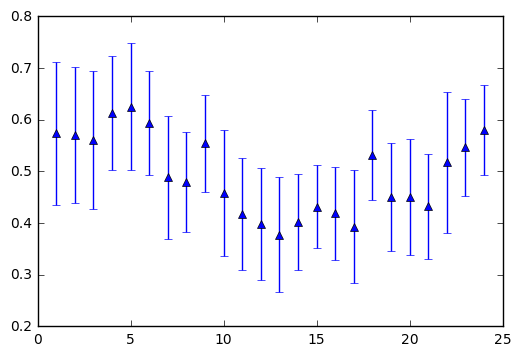

In [298]:
plt.errorbar(time_frame, full_acc_score, full_acc_std, linestyle='None', marker='^')
plt.show()   

In [301]:
roc_auc_score = []
for i in range(0,24):
    fpr, tpr, thresholds = roc_curve(Y_true[i], decision_function[i])
#     fpr, tpr, thresholds = roc_curve(Y_true[i], Y_proba[i][:,1])
    roc_auc = auc(fpr, tpr)
    roc_auc_score.append(roc_auc)

Area is 0.62


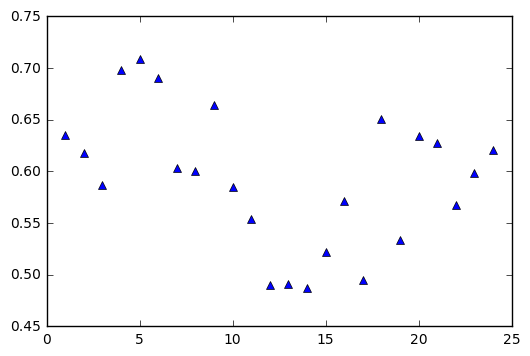

In [302]:
print('Area is %0.2f' %roc_auc)
plt.plot(time_frame, roc_auc_score, linestyle='None', marker='^')
plt.show()   


In [285]:
full_param

[{'C': 1.0000000000000001e-15,
  'class_weight': 'balanced',
  'max_iter': 10000,
  'solver': 'newton-cg'},
 {'C': 0.0001,
  'class_weight': 'balanced',
  'max_iter': 10000,
  'solver': 'newton-cg'},
 {'C': 0.0001, 'class_weight': None, 'max_iter': 10000, 'solver': 'newton-cg'},
 {'C': 1.0000000000000001e-15,
  'class_weight': 'balanced',
  'max_iter': 10000,
  'solver': 'newton-cg'},
 {'C': 0.01, 'class_weight': None, 'max_iter': 10000, 'solver': 'newton-cg'},
 {'C': 10.0, 'class_weight': None, 'max_iter': 10000, 'solver': 'newton-cg'},
 {'C': 1.0000000000000001e-15,
  'class_weight': 'balanced',
  'max_iter': 10000,
  'solver': 'newton-cg'},
 {'C': 0.01, 'class_weight': None, 'max_iter': 10000, 'solver': 'newton-cg'},
 {'C': 0.001, 'class_weight': None, 'max_iter': 10000, 'solver': 'newton-cg'},
 {'C': 10.0,
  'class_weight': 'balanced',
  'max_iter': 10000,
  'solver': 'newton-cg'},
 {'C': 0.01, 'class_weight': None, 'max_iter': 10000, 'solver': 'newton-cg'},
 {'C': 0.001,
  'class_

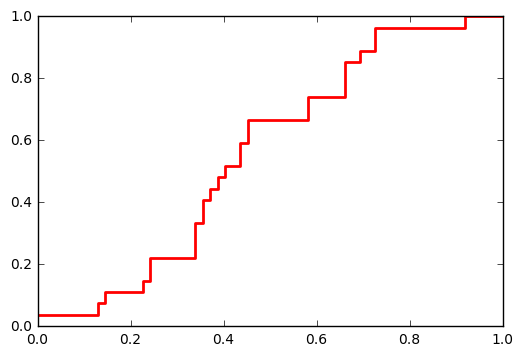

In [276]:
plt.plot(fpr, tpr, lw=2, color='red', label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
plt.show()


3.707105875015259
3.742274045944214
3.5079729557037354
3.6441001892089844
3.9666078090667725
3.8929247856140137
3.773789405822754
3.6083827018737793
4.952988624572754
4.513566493988037
3.921849250793457
3.6197729110717773
3.4554800987243652
3.6146633625030518
4.02409291267395
4.190800428390503
4.377596378326416
5.500088691711426
4.295209169387817
5.3158955574035645
4.368031978607178
7.606017827987671
5.0047056674957275
6.065720796585083


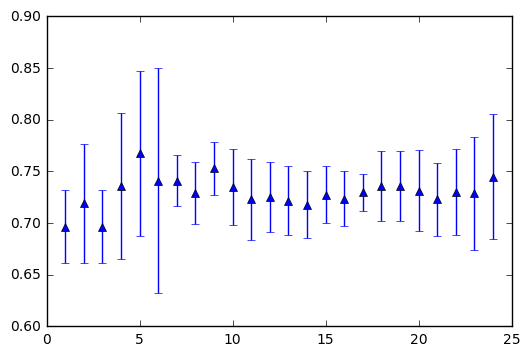

In [39]:
# Plot accuracy score
import warnings
warnings.filterwarnings('ignore')

full_acc_score = []
full_acc_std = []
time_frame = range(1,25)
for count in range(1, 25):
    datapath = 'D:/Dropbox (Nate)/Rotation 3 Project/Data/FeatData/featurematrixandtarget_%sh' % count
#     datapath='/Users/ignacioperez-pozuelo/Dropbox/Rotation 3 Project/Data/FeatData/featurematrixandtarget_%sh'%count
    sc = get_score(datapath, None)
    full_acc_score.append(sc[0])
    full_acc_std.append(sc[1])

plt.errorbar(time_frame, full_acc_score, full_acc_std, linestyle='None', marker='^')
plt.show()   
    

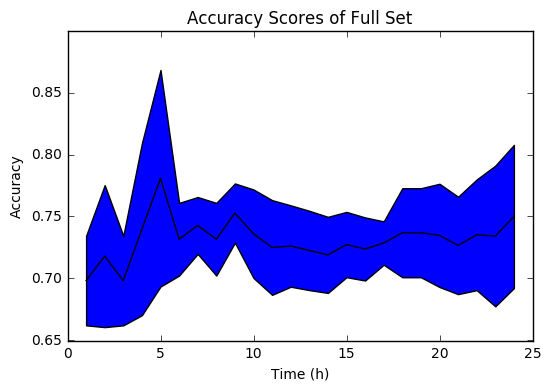

In [12]:
plt.plot(time_frame,full_acc_score, 'k-')
# upbound = full_acc_score + full_acc_std;
# # lowbound = full_acc_score - full_acc_std;
# plt.fill_between(time_frame,upbound);
plt.fill_between(time_frame,np.array(full_acc_score)-np.array(full_acc_std),np.array(full_acc_score)+np.array(full_acc_std))
plt.title('Accuracy Scores of Full Set')
plt.xlabel('Time (h)')
plt.ylabel('Accuracy')
plt.show()

/Users/ignacioperez-pozuelo/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:5: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/Users/ignacioperez-pozuelo/anaconda/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/ignacioperez-pozuelo/anaconda/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


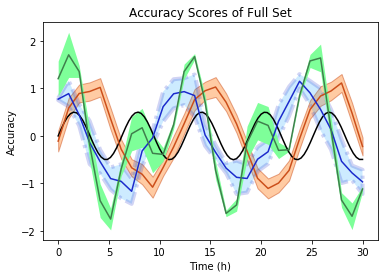

In [36]:
from matplotlib import pyplot as pl
import numpy as np

# Plot Generated with Dummy Data
pl.clf()
pl.hold(1)

x = np.linspace(0, 30, 100)
y = np.sin(x) * 0.5
pl.plot(x, y, '-k')


x = np.linspace(0, 30, 30)
y = np.sin(x/6*np.pi)
error = np.random.normal(0.1, 0.02, size=y.shape) +.1
y += np.random.normal(0, 0.1, size=y.shape)

pl.plot(x, y, 'k', color='#CC4F1B')
pl.fill_between(x, y-error, y+error,
    alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')

y = np.cos(x/6*np.pi)    
error = np.random.rand(len(y)) * 0.5
y += np.random.normal(0, 0.1, size=y.shape)
pl.plot(x, y, 'k', color='#1B2ACC')
pl.fill_between(x, y-error, y+error,
    alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
    linewidth=4, linestyle='dashdot', antialiased=True)



y = np.cos(x/6*np.pi)  + np.sin(x/3*np.pi)  
error = np.random.rand(len(y)) * 0.5
y += np.random.normal(0, 0.1, size=y.shape)
pl.plot(x, y, 'k', color='#3F7F4C')
pl.fill_between(x, y-error, y+error,
    alpha=1, edgecolor='#3F7F4C', facecolor='#7EFF99',
    linewidth=0)

plt.title('Accuracy Scores of Full Set')
plt.xlabel('Time (h)')
plt.ylabel('Accuracy')

pl.show()

In [41]:
k = np.array(full_acc_score)
k

array([ 0.69833333,  0.71805556,  0.69833333,  0.73972222,  0.78083333,
        0.73166667,  0.74277778,  0.73166667,  0.75277778,  0.73611111,
        0.725     ,  0.72619048,  0.72261905,  0.71904762,  0.72738095,
        0.72380952,  0.72857143,  0.73690476,  0.73690476,  0.7347619 ,
        0.72666667,  0.7352381 ,  0.73428571,  0.75      ])

C:\Users\ntran\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)
C:\Users\ntran\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)
C:\Users\ntran\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)
C:\Users\ntran\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='b

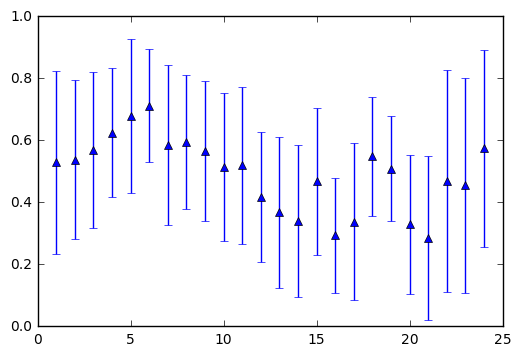

In [30]:
# Plot area under the curve

full_auc_score = []
full_auc_std = []
time_frame = range(1,25)
for count in range(1, 25):
    datapath = 'D:/Dropbox (Nate)/Rotation 3 Project/Data/FeatData/featurematrixandtarget_%sh' % count
#     datapath='/Users/ignacioperez-pozuelo/Dropbox/Rotation 3 Project/Data/FeatData/featurematrixandtarget_%sh'
    sc = get_score(datapath, 'roc_auc')
    full_auc_score.append(sc[0])
    full_auc_std.append(sc[1])
plt.errorbar(time_frame, full_auc_score, full_auc_std, linestyle='None', marker='^')
plt.show()
   


C:\Users\ntran\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


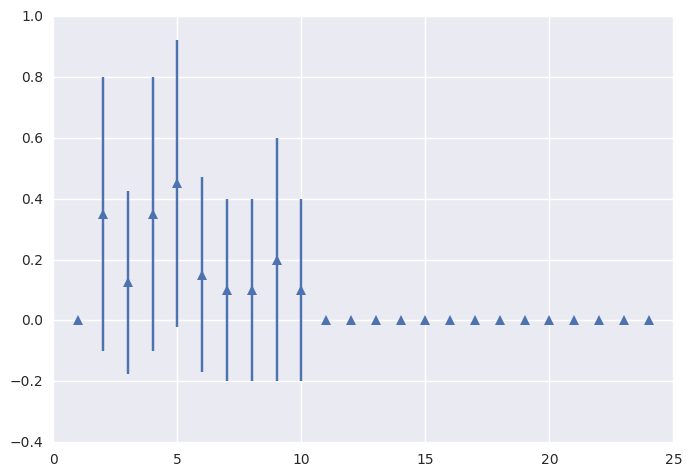

In [522]:
# Plot precsion score

full_pre_score = []
full_pre_std = []
time_frame = range(1,25)
for count in range(1, 25):
    datapath = 'D:/Dropbox (Nate)/Rotation 3 Project/Data/FeatData/featurematrixandtarget_%sh' % count
    sc = get_accuracy_score(datapath, 'precision')
    full_pre_score.append(sc[0])
    full_pre_std.append(sc[1])
plt.errorbar(time_frame, full_pre_score, full_pre_std, linestyle='None', marker='^')
plt.show()

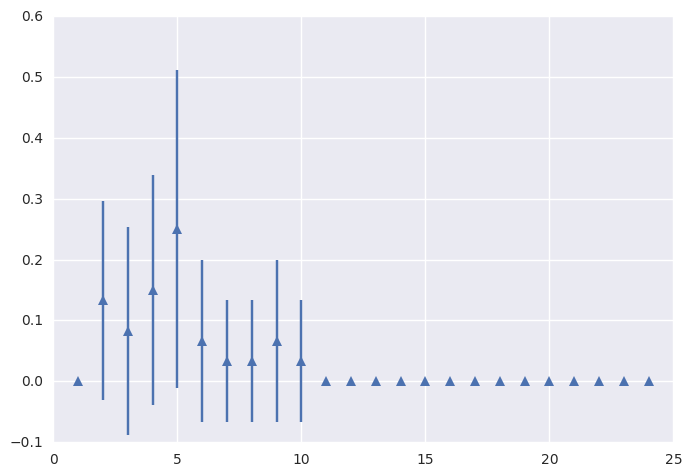

In [523]:
# Plot recall score

full_recall_score = []
full_recall_std = []
time_frame = range(1,25)
for count in range(1, 25):
    datapath = 'D:/Dropbox (Nate)/Rotation 3 Project/Data/FeatData/featurematrixandtarget_%sh' % count
    sc = get_accuracy_score(datapath, 'recall')
    full_recall_score.append(sc[0])
    full_recall_std.append(sc[1])
plt.errorbar(time_frame, full_recall_score, full_recall_std, linestyle='None', marker='^')
plt.show()

In [14]:
import pickle


# with open('D:/Dropbox (Nate)/Rotation 3 Project/Models/RFcvgridsearch_01h.pkl', 'rb') as f:
with open('/Users/ignacioperez-pozuelo/Dropbox/Rotation 3 Project/Models/RFcvgridsearch_01h.pkl', 'rb') as f:
    data = pickle.load(f).replace('\r\n', '\n')

# data = open("D:/Dropbox (Nate)/Rotation 3 Project/Models/RFcvgridsearch_01h.pkl", "rb").read()
# data = open("/Users/ignacioperez-pozuelo/Dropbox/Rotation 3 Project/Models/RFcvgridsearch_01h.pkl", "rb").read()

# newdata = data.replace("\n","\r\n")
# if newdata != data:
#     f = open("D:/Dropbox (Nate)/Rotation 3 Project/Models/RFcvgridsearch_01h.pkl", "wb")
#     f.write(newdata)
#     f.close()
# data

/Users/ignacioperez-pozuelo/anaconda/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.18 when using version 0.18.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/ignacioperez-pozuelo/anaconda/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.18 when using version 0.18.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


UnpicklingError: invalid load key, '\x00'.